# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

### Загрузка библиотек и данных:

Загрузка библиотек: 

In [1]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import re


Загрузка данных:

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

### Ознакомление с данными:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В таблице присутствуют столбцы с данными разных типов. Тип в основном соответствует описанию, за исключением столбца `is_apartment`.  
Количество пропусков в большинстве столбцов (кроме столбца `is_apartment`) находится в разумных пределах. 

Рассмотрим содержимое первых 5 строк таблицы:

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Содержимое ячеек соответствует смыслу столбцов.  
Рассмотрим распределения количественных данных:

In [5]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Статистики распределений выглядят правдоподобно. Сомнения вызываются некоторые максимальные значения. Например высота потолков (`ceiling_height`) в 100 м является явно ошибочной.

### Вывод

Тип данных в стобцах в основном соответствует описанию, за исключением столбца `is_apartment`. Содержимое ячеек также соответствует смыслу столбцов.  
Количество пропусков в большинстве столбцов (кроме столбца `is_apartment`) находится в разумных пределах.

## Предобработка данных

### Анализ пропусков

Определим долю пропусков в столбцах:

In [6]:
data.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

#### Анализ пропусков в столбце `is_apartment`

Наиболее проблемным столбцом является `is_apartment`. Рассмотрим значения содержащиеся в этом столбце:

In [7]:
#Уникальные значения:
print(data.is_apartment.unique())

#Доля различных значений: 
data.is_apartment.value_counts()/len(data)

[nan False True]


False    0.114984
True     0.002110
Name: is_apartment, dtype: float64

Вероятно пропущенные значения соответвуют `False` - если тип недвижимости не аппартаменты, пользователи ничего не отмечают.  
Доля значений `True` меньше 0,2%, поэтому правильно будет полностью исключить данный столбец.

In [8]:
data = data.drop('is_apartment', axis=1)

#### Анализ пропусков в столбцах  `parks_nearest` и `ponds_nearest` и другими географическими параметрами

Следующее место по максимальной доле пропусков занимают столбцы `parks_nearest` и `ponds_nearest`. Рассмотрим строки с отсутствующими значениями:

In [9]:
#Список географических параметров:
geo_parameters = ['locality_name', 'airports_nearest', 'cityCenters_nearest',
        'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest',
        'days_exposition']

data[data['parks_nearest'].isna()][geo_parameters].head()

,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
5,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0


Выделяется две причины пропусков в столбцах `parks_nearest` и `ponds_nearest` - отсутствие парков и прудов в пределах 3 км (0 в столбцах `parks_around3000` и `ponds_around3000` соответственно) и полное отсутствие автоматически сгенерированных из географических данных столбцов. Возможно такие пользователи не указали точное положение объекта недвижимости.  
Пропуски, связанные с отсутствием прудов и парков исправим, добавив фиктивное значение, заведомо превышающее верхнуюю границу, например 4000.

In [10]:
# Добавление значений в столбец 'parks_nearest'
data.loc[(data['parks_around3000'] == 0) & (data['parks_nearest'].isna()), 'parks_nearest'] = 4000
# Добавление значений в столбец 'ponds_nearest'
data.loc[(data['ponds_around3000'] == 0) & (data['ponds_nearest'].isna()), 'ponds_nearest'] = 4000

Пропуски, вызванные отсутствием данных о положение объекта, нельзя заполнить какими-либо значениями.  
Чтобы учеть отсутствие точного положения, добавим дополнительный столбец `position_given`

In [11]:
# Заполним на основании столбца с парками:
data['position_given'] = data['parks_around3000'].notna()

# Проверим, исправляет ли это проблемы с другими географическими параметрами:
data[data['position_given']].isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.364116
floors_total            0.004180
living_area             0.070403
floor                   0.000000
studio                  0.000000
open_plan               0.000000
kitchen_area            0.085969
balcony                 0.484517
locality_name           0.002255
airports_nearest        0.001320
cityCenters_nearest     0.000055
parks_around3000        0.000000
parks_nearest           0.000000
ponds_around3000        0.000000
ponds_nearest           0.000000
days_exposition         0.127386
position_given          0.000000
dtype: float64

In [12]:
data[(data['position_given']) & (data['airports_nearest'].isna())].head(10)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,position_given
733,18,18700000.0,109.7,2018-02-03T00:00:00,3,2.75,21.0,57.2,13,False,...,1.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,4000.0,112.0,True
974,8,25897000.0,149.0,2018-03-26T00:00:00,4,2.74,7.0,NaN,6,False,...,NaN,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,90.0,True
2415,17,9500000.0,67.4,2017-04-15T00:00:00,2,2.80,23.0,37.6,4,False,...,0.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,4000.0,56.0,True
7521,16,43500000.0,245.8,2015-12-17T00:00:00,3,4.45,7.0,170.8,7,False,...,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,4000.0,1067.0,True
7542,10,6900000.0,50.0,2016-03-17T00:00:00,1,2.80,23.0,20.0,12,False,...,0.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,4000.0,317.0,True
8018,20,84000000.0,507.0,2015-12-17T00:00:00,5,4.45,7.0,301.5,7,False,...,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,4000.0,1078.0,True
8628,0,8000000.0,48.9,2018-02-23T00:00:00,1,NaN,6.0,NaN,4,False,...,NaN,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,4000.0,60.0,True
9054,5,13000000.0,71.8,2017-09-12T00:00:00,2,2.75,10.0,32.5,5,False,...,2.0,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,156.0,True
9880,11,5300000.0,51.0,2018-01-10T00:00:00,2,NaN,5.0,22.6,4,False,...,NaN,Санкт-Петербург,NaN,4892.0,0.0,4000.0,2.0,369.0,13.0,True
10669,9,3400000.0,46.0,2018-09-01T00:00:00,2,2.60,5.0,28.0,5,False,...,NaN,Санкт-Петербург,NaN,21377.0,0.0,4000.0,0.0,4000.0,106.0,True


Такой подход позволил исключить все пропуски в расстоянии до ближайшего парка/пруда при наличии сведений о количестве парков/прудов в окрестности. При последующем анализе необходимо учитывать что добавленные значения (4000) являются фиктивными.  

Осталась небольшая доля пропусков в столбцах `locality_name`, `airports_nearest` и `cityCenters_nearest`. Учитывая малое количество таких пропусков они могут быть исключены или проигнорированы. Удалим их: 

In [13]:
data.drop(
    data[
        (data['position_given'])
        & (
            (data['airports_nearest'].isna()) |
            (data['cityCenters_nearest'].isna())
            ) 
        | (data['locality_name'].isna())
            ].index,
    inplace=True
)

In [14]:
data[data['position_given']].isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.363677
floors_total            0.004140
living_area             0.070328
floor                   0.000000
studio                  0.000000
open_plan               0.000000
kitchen_area            0.085785
balcony                 0.485785
locality_name           0.000000
airports_nearest        0.000000
cityCenters_nearest     0.000000
parks_around3000        0.000000
parks_nearest           0.000000
ponds_around3000        0.000000
ponds_nearest           0.000000
days_exposition         0.127684
position_given          0.000000
dtype: float64

#### Анализ пропусков в столбце `balcony` и `ceiling_height` и других.

Следующее место по максимальной доле пропусков занимают столбцы `balcony` и `ceiling_height`. Рассмотрим строки с пропусками в столбце `balcony`.

In [15]:
data[data['balcony'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,position_given
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,True
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,True
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,False,...,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,False
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,False,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,False
10,5,5050000.0,39.60,2017-11-16T00:00:00,1,2.67,12.0,20.30,3,False,...,NaN,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,True


Данные представляются правдоподобными в остальных отношениях. Вероятно отсутствие значения количества балконов связано с отсутствием балконов в квартире. Заполним пропуски значением `0`.

In [16]:
data['balcony'].fillna(0, inplace=True)

Отсутствующие значения высоты потолка заполним медианой.

In [17]:
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

В столбце `floors_total` доля пропусков мала и они могут быть полностью исключены:

In [18]:
data.dropna(subset=['floors_total'], inplace=True)

Довольно много пропусков содержится в столбце `days_exposition`. Такие пропуски могли возникнуть при снятии объявления в день размещения из-за ошибок или в случае если объявление до сих пор активно.  

Если ошибки связаны со снятием объявления в день размещения в таблице должны отсутствовать нулевые значения:

In [19]:
data['days_exposition'].value_counts().sort_index().head()

1.0      1
2.0      3
3.0    157
4.0    174
5.0    152
Name: days_exposition, dtype: int64

Действительно нулевые значения остутствуют, первое предположение может быть справедливым.  

Если причина в том, что объявление до сих пор активно большинство пропусков должно приходится на конец выборки:

<AxesSubplot:>

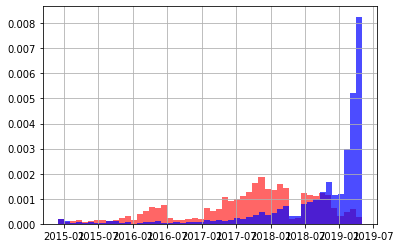

In [20]:
#Гистограмма распределения даты размещения для объявлений с указанной продолжительностью размещения:

(pd.to_datetime(data[data['days_exposition'].notna()].first_day_exposition)
     .hist(bins=50, facecolor='red', density=True, alpha=0.6)
)

#Гистограмма распределения даты размещения для объявлений с пропущенной продолжительностью размещения:
(pd.to_datetime(data[data['days_exposition'].isna()].first_day_exposition)
     .hist(bins=50, density=True, facecolor='blue', alpha=0.7)
)

Действительно среди объявлений с пропуском в столбце `days_exposition` преобладают относительно свежие объявления.  

Таким образом обе высказанные причины могут иметь место, причем в обоих случаях указанные в объявлении параметры *могут быть* не рыночными либо не адекватными в принципе. Однако большая доля пропусков не позволяет исключить их.  

Заполним пропуски разницей между днем следующим за днем размещения последнего объявления (вероятно совпадающим с датой выгрузки и датой размещения объявлений.


In [21]:
surrogate_days = pd.to_datetime(data['first_day_exposition'].max()) - pd.to_datetime(data.loc[data['days_exposition'].isna(), 'first_day_exposition'])

data.loc[data['days_exposition'].isna(), 'days_exposition'] = surrogate_days.dt.days + 1

Наиболее подозрительными объявлениями с пропусками в столбце `days_exposition` являются "слишком старые" объявления. Такие объявления будут исключены позднее, на шаге обработки аномалий.

#### Вывод

Доли оставшихся пропусков:

In [22]:
data.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.000000
floors_total            0.000000
living_area             0.079142
floor                   0.000000
studio                  0.000000
open_plan               0.000000
kitchen_area            0.094308
balcony                 0.000000
locality_name           0.000000
airports_nearest        0.233645
cityCenters_nearest     0.233645
parks_around3000        0.233645
parks_nearest           0.233645
ponds_around3000        0.233645
ponds_nearest           0.233645
days_exposition         0.000000
position_given          0.000000
dtype: float64

В большинстве столбцов пропуски были полностью исключены.  
В столбцах `living_area` и `kitchen_area` доля пропусков достаточно велика (7,9 и 9,4 %), нежелательно их полностью исключать. Жилая площадь и площадь кухню, должны составлять определённую долю от общей площади. Однако такая доля будет разной для квартир разного класса, что требует дополнительного рассмотрения данных.  
В столбцах, соответствующих георгафическим данным, осталось по 23 % пропусков. Вероятно такие пропуски соответствуют объектам, для которых не дан адрес.

### Изменение типов данных

Имеющиеся типы данных:

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23540 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23540 non-null  int64  
 1   last_price            23540 non-null  float64
 2   total_area            23540 non-null  float64
 3   first_day_exposition  23540 non-null  object 
 4   rooms                 23540 non-null  int64  
 5   ceiling_height        23540 non-null  float64
 6   floors_total          23540 non-null  float64
 7   living_area           21677 non-null  float64
 8   floor                 23540 non-null  int64  
 9   studio                23540 non-null  bool   
 10  open_plan             23540 non-null  bool   
 11  kitchen_area          21320 non-null  float64
 12  balcony               23540 non-null  float64
 13  locality_name         23540 non-null  object 
 14  airports_nearest      18040 non-null  float64
 15  cityCenters_nearest

Дата размещения объявления `first_day_exposition` представлена в виде строки. Преобразуем её в формат даты:

In [24]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

Ряд столбцов `total_images`, `rooms`, `floors_total`, `floor`, `balcony`, `parks_around3000`, `ponds_around3000` и `days_exposition` соответствуют параметрам, описываем целыми неотрицательными числами.  
NaN'ы в столбцах `ponds_around3000` и `parks_around3000` не позволяет перевести их в целые, учитывая малость значений представим их в виде дробных чисел небольшой точности: 

In [25]:
# Столбцы с целыми, неотрицательными значениями:
uint_cols = ['total_images', 'rooms', 'floors_total',
         'floor', 'balcony', 'days_exposition']


data[uint_cols] = data[uint_cols].astype('uint16')

data[['parks_around3000', 
      'ponds_around3000']] = data[['parks_around3000', 
                                   'ponds_around3000']].astype('float16')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23540 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23540 non-null  uint16        
 1   last_price            23540 non-null  float64       
 2   total_area            23540 non-null  float64       
 3   first_day_exposition  23540 non-null  datetime64[ns]
 4   rooms                 23540 non-null  uint16        
 5   ceiling_height        23540 non-null  float64       
 6   floors_total          23540 non-null  uint16        
 7   living_area           21677 non-null  float64       
 8   floor                 23540 non-null  uint16        
 9   studio                23540 non-null  bool          
 10  open_plan             23540 non-null  bool          
 11  kitchen_area          21320 non-null  float64       
 12  balcony               23540 non-null  uint16        
 13  locality_name   

Остающиеся типы данных соответствуют смыслу содержимого столбцов.  
Дробные значения в случае данного исследования не требуют двойной точности и при увеличении размера анализируемого датасета целесообразно преобразовать их в числа меньшей точности. 

### Обработка названий населённых пунктов

Поскольку название населенного пункта вводилось пользователями, следует ожидать наличия разных вариантов одного и того же названия.  
Рассмотрим названия населённых пунктов в таблице:

In [27]:
n_before = len(data['locality_name'].sort_values().unique())

data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Можно отметить двойные варианты написания:
- "поселок"/"посёлок",
- "городской поселок" / "поселок городского типа"
- "посёлок при железнодорожной станции"/"посёлок станции"

Наиболее простым решением будет исключить из названия тип населенного пункта. При этом потенциально возможно объединение разных населенных пунктов, однако не массовое.
Наиболее правильным было бы дать пользователям выбирать населенные пункты на карте и заносить в таблицы идентификатор населенного пункта (например почтовый инидекс или др.), поскольку даже при правильном заполнении возможны населенные пункты "тезки".  
  
Создадим фукнцию для обработки названий населенных пунктов.

In [28]:
def remove_city_type(locality_name):
    try:
    #будем искать последовательность символов начинающуюся с большой буквы
        return re.findall(r'[А-Я].*', locality_name)[0]
    except:
        return "что-то пошло не так"

print(remove_city_type('садоводческое некоммерческое товарищество Лесная Поляна'))
print(remove_city_type('Бокситогорск'))

Лесная Поляна
Бокситогорск


Функция работает ожидаемым образом. Удалим типы населенных пунктов из столбца `locality_name`

In [29]:
data['locality_name'] = data['locality_name'].apply(remove_city_type)
data['locality_name'].sort_values().unique()[:30]

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы'], dtype=object)

In [30]:
n_after = len(data['locality_name'].unique())
print(f'Число уникальных населенных пунктов до обработки: {n_before}')
print(f'Число уникальных населенных пунктов до обработки: {n_after}')

Число уникальных населенных пунктов до обработки: 364
Число уникальных населенных пунктов до обработки: 305


Тип населенных пунктов был удален, это позволило исключить 59 дубликатов среди наименований населенных пунктов.

## Расчёты и добавление результатов в таблицу

### Расчёт и добавление цены квадратного метра

Рассчитаем цену квадратного метра объектов и добавим её в таблицу:

In [31]:
data['price_per_square'] = data['last_price'] / data['total_area']

### Расчёт и добавление временных параметров публикации объявления

Определим и добавим в таблицу день недели, месяц и год для каждого опубликованного объявления:

In [32]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

### Классификация объектов по этажам

Создадим функцию-классификатор этажа, на котором находится продаваемый объект:

In [33]:
def floor_classifier(row):
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'

Классифицируем объекты по этажу:

In [34]:
data['floor_class'] = data.apply(floor_classifier, axis=1)
data['floor_class'] = data['floor_class'].astype(pd.CategoricalDtype(["первый", "другой", "последний"], ordered=True))
data['floor_class'].value_counts()

другой       17307
последний     3326
первый        2907
Name: floor_class, dtype: int64

### Расчёт и добавление долей кухонной и жилой площади 

Рассчитаем отношение жилой площади к общей и площади кухни к общей площади:

In [35]:
data['living_area_ratio'] = data['living_area'] / data['total_area']

data['kitchen_area_ratio'] = data['kitchen_area'] / data['total_area']


### Вывод

Требуемые параметры (цена квадратного метра, доля кухонной и жилой площади, день, месяц и год публикации объявления) расчитаны и добавлены в таблицу. 

## Исследовательский анализ данных

### Распределение объектов недвижимости по параметрам

Построим параметры распределений площади, цены, числа комнат и высоты потолков:

In [36]:
data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23540.000000,2.354000e+04,23540.000000,23540.000000
mean,60.265686,6.527275e+06,2.070178,2.724263
std,35.409982,1.088540e+07,1.078153,0.991328
min,12.000000,1.219000e+04,0.000000,1.000000
25%,40.000000,3.400000e+06,1.000000,2.600000
50%,52.000000,4.630000e+06,2.000000,2.650000
75%,69.632500,6.760848e+06,3.000000,2.700000
max,900.000000,7.630000e+08,19.000000,100.000000


Параметры распределений различаются. Так для общей площади все наблюдаемые значения являются в общем-то правдоподобными, в то время как и минимальная и максимальная высота потолка являются очевидно ошибочными. 
Познакомимся с распределениями подробнее, построив гистограммы.  

Text(0.5, 1.0, 'Высота потолков')

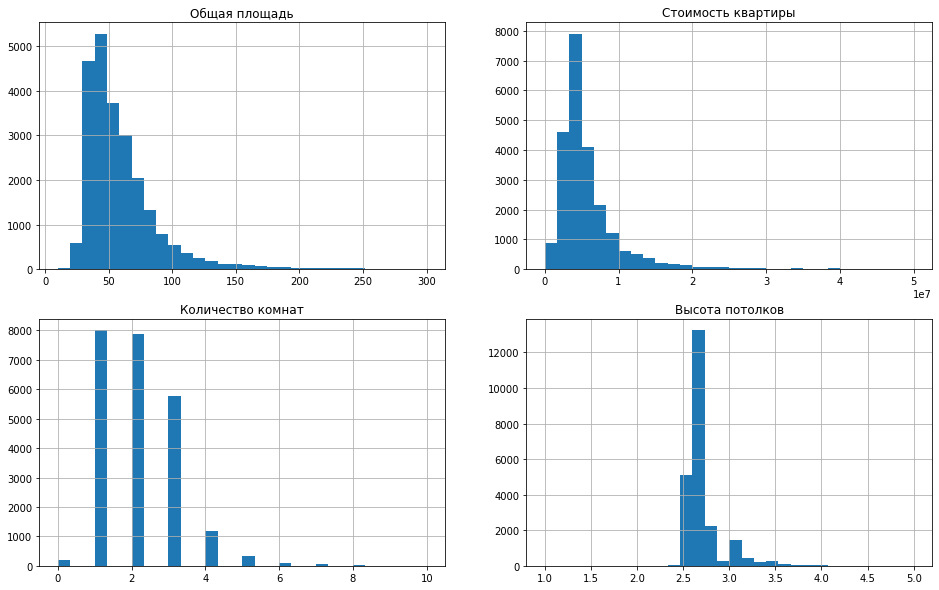

In [37]:
fix, axes = plt.subplots(2, 2, figsize=(16,10))

data['total_area'].hist(range=(10,300),bins=30, ax=axes[0,0])
axes[0,0].set_title('Общая площадь')

data['last_price'].hist(range=(1,5e7), bins=30, ax=axes[0,1])
axes[0,1].set_title('Стоимость квартиры')

data['rooms'].hist(range=(0,10), bins=30, ax=axes[1,0])
axes[1,0].set_title('Количество комнат')

data['ceiling_height'].hist(range=(1,5), bins=30, ax=axes[1,1])
axes[1,1].set_title('Высота потолков')


   Как было указано площади квартир являются правдоподобными. Минимальная площадь ограничена естественным образом (около 12 кв. м), максимальная же площадь теоретически не ограничена, однако слишком большие квартиры встречаются редко.  
    Распределение площади практически мономодальное с максимумом около 50 кв. м. Наблюдается также меньшая мода около 150 кв. м., вероятно соответствующая наиболее распространенным квартирам "комфорт-класса".  
    Редкие слишком большие квартиры могут исказить общие выводы, кроме того слишком большие площади могут быть указаны просто по ошибке. Чтобы избежать обоих моментов целесообразность удалить квартиры слишком большой площади. В качестве границы используем 99% квантиль распределения:

In [38]:
ultra_large_area = data['total_area'].quantile(0.99)
print(f"Площадь 1% самых больших квартир > {ultra_large_area:0.0f} кв. м")

Площадь 1% самых больших квартир > 197 кв. м


Площадь квартир ограниченная 99% квантилем хорошо согласуется с гистограммой, позволяет захватить обе моды распределения, исключив слишком большие квартиры.

Распределение цены квартир также имеет вид распределения Пуассона. Аналогично распределению по площади имеет смысл исключить из рассмотрения слишком дорогие квартиры. Порогом "слишком дорогих" квартир является цена в 20 - 40 млн. Определим пороговое значение как 99% квантиль распределения:

In [39]:
print(f"Цена 99% квартир не превышает: {data['last_price'].quantile(0.99):0.0f}")

Цена 99% квартир не превышает: 35981867


Полученное пороговое значение (около 36 млн.) хорошо согласуется с гистограммой распределения и позволяет учесть часть относительно дорогих квартир.

Распределение квартир по числу комнат почти нормальное, большинство объявлений приходится на самые распространенные 1-о, 2-ух и 3-ех комнатные квартиры. При этом присутствуют квартиры с большим числом комнат (до 19). 

Квартиры, имеющие больше 5 комнат, являются весьма редкими и специфическими.  
Также указано 0,82% квартир с числом комнат равным нулю, что очевидно является ошибкой - возможно пользователь просто не указал число комнат.

In [40]:
zero_rooms = np.mean(data['rooms']==0)
more_5_rooms = np.mean(data['rooms']>5)

print(f"Доля квартир без комнат: {zero_rooms:0.3%}")
print(f"Доля квартир более 5 комнат: {more_5_rooms:0.3%}")

Доля квартир без комнат: 0.824%
Доля квартир более 5 комнат: 0.820%


Распределение квартир по высоте потолка напоминает распределение Пуассона. Однако можно выделить два максимума, возможно связанные с разными годами постройки объектов и соответственно с разными строительными нормами.  

Высота потолка в большинстве квартир меньше 3,5 м.

### Распределение объектов по продолжительности продажи

Гистограмма распределения объектов по продолжительности продажи:

<AxesSubplot:>

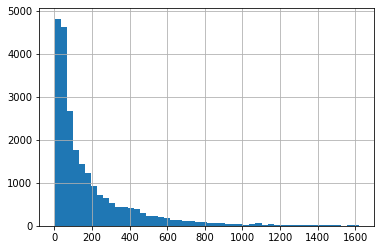

In [41]:
data['days_exposition'].hist(bins=50)

In [42]:
data['days_exposition'].describe()

count    23540.000000
mean       185.859686
std        233.450980
min          1.000000
25%         43.000000
50%         94.000000
75%        237.000000
max       1619.000000
Name: days_exposition, dtype: float64

Распределение является весьма правдоподобным и не вызывает сомнений.  
Распределение не является нормальным и имеет сильно вытянутый вправо хвост. Наличие длинного хвоста справа приводит к существенному различию среднего и медианного значений длительности продажи (186 и 94 дней соответственно).  
Судя по форме распределения, продажа квартиры может происходить сколь угодно долго, хотя в большинстве случаев происходит не дольше чем за 1000 дней (т.е. примерно 2,5 года). Пороговое значение "нормальной" продолжительности продажи определим по 999% квантилю распределения.

In [43]:
data['days_exposition'].quantile(0.99)

1135.0

Объявления с продолжительностью демонстрации более 1135 дней должны быть исключены, поскольку могут содержать далекие от рыночных условия.  
Помимо слишком долго демонстрируемых подозрительными являются также объявления снятые слишком рано. Рассмотрим подробнее левую часть распределения:

<AxesSubplot:>

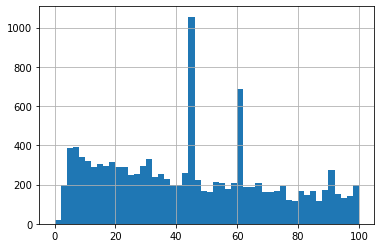

In [44]:
data['days_exposition'].hist(range=(0,100), bins=50)

In [45]:
data['days_exposition'].value_counts().sort_values(ascending=False).head(3)

45    894
60    558
7     248
Name: days_exposition, dtype: int64

Cомнения вызывают пики около 45 и 60 дней. Не ясна причина таких выбросов, учитывая слишком правильные значения можно предположить что они связаны с работой системы размещения объявлений (например необходимость продления размещения объявлений).    
Суммарная доля таких аномальных значений:

In [46]:
((data['days_exposition'] == 60) | (data['days_exposition'] == 45)).mean()

0.0616822429906542

Доля аномальных значений довольно велика. Чтобы решить вопрос о необходимости их исключения сравним показатели для объявлений, снятых ровно после 60 дней, и объявлений размещенных более 60 дней (в случае меньшей продложительности данные могут быть искажены особенно выгодными предложениями):

In [47]:
display(data[(data['days_exposition'] == 60)].describe())

display(data[(data['days_exposition'] > 60)].describe())

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,weekday,month,year,living_area_ratio,kitchen_area_ratio
count,558.000000,5.580000e+02,558.000000,558.000000,558.000000,558.000000,371.000000,558.000000,379.000000,558.000000,...,480.00000,480.000000,480.000000,558.0,558.000000,558.000000,558.000000,558.000000,371.000000,379.000000
mean,9.227599,6.015754e+06,60.314713,2.152330,2.689140,13.005376,34.121590,7.000000,10.811372,0.612903,...,2635.31875,0.735352,2263.435417,60.0,102619.920537,2.763441,6.424731,2017.630824,0.563667,0.189149
std,5.756285,1.769919e+06,17.537977,0.886819,0.178602,7.108417,13.344022,5.299978,3.904032,0.953485,...,1716.69709,0.882812,1748.698574,0.0,25685.820464,1.884823,3.735976,0.736275,0.107148,0.070941
min,0.000000,1.020000e+06,23.000000,0.000000,2.500000,1.000000,8.500000,1.000000,4.800000,0.000000,...,13.00000,0.000000,35.000000,60.0,21428.571429,0.000000,1.000000,2016.000000,0.240793,0.075758
25%,5.000000,4.900000e+06,48.000000,2.000000,2.650000,7.000000,22.950000,3.000000,8.100000,0.000000,...,575.00000,0.000000,505.250000,60.0,84877.730884,1.000000,3.000000,2017.000000,0.500000,0.137784
50%,9.000000,5.751000e+06,58.900000,2.000000,2.650000,12.000000,33.000000,5.000000,10.000000,0.000000,...,4000.00000,0.500000,2609.500000,60.0,100850.729344,3.000000,7.000000,2018.000000,0.571429,0.173077
75%,13.000000,6.985000e+06,72.000000,3.000000,2.700000,17.750000,43.600000,10.000000,12.345000,1.000000,...,4000.00000,1.000000,4000.000000,60.0,116140.732119,4.000000,10.000000,2018.000000,0.631989,0.229184
max,32.000000,1.390000e+07,132.000000,6.000000,4.190000,27.000000,78.000000,25.000000,30.000000,5.000000,...,4000.00000,3.000000,4000.000000,60.0,210176.991150,6.000000,12.000000,2019.000000,0.927562,0.500000


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,weekday,month,year,living_area_ratio,kitchen_area_ratio
count,14628.000000,1.462800e+04,14628.000000,14628.000000,14628.000000,14628.000000,13818.000000,14628.000000,13597.000000,14628.000000,...,11264.000000,11264.000000,11264.000000,14628.000000,1.462800e+04,14628.000000,14628.000000,14628.000000,13818.000000,13597.000000
mean,10.027208,7.081720e+06,63.725932,2.164958,2.733527,10.413932,36.312008,5.748154,10.909863,0.582650,...,2385.286222,0.806152,2209.456676,280.172819,1.004626e+05,2.550109,6.478808,2017.062825,0.565778,0.184954
std,5.586288,1.103604e+07,38.064886,1.123561,0.754281,6.566136,23.433622,4.852865,6.291520,0.965851,...,1763.745556,0.963379,1756.870462,253.022860,5.160271e+04,1.777196,3.502067,1.030580,0.105710,0.073770
min,0.000000,4.500000e+05,12.000000,0.000000,1.200000,1.000000,2.000000,1.000000,2.000000,0.000000,...,3.000000,0.000000,13.000000,61.000000,9.615385e+03,0.000000,1.000000,2014.000000,0.021583,0.025381
25%,6.000000,3.499750e+06,41.342500,1.000000,2.600000,5.000000,19.000000,2.000000,7.200000,0.000000,...,480.000000,0.000000,476.000000,106.000000,7.600000e+04,1.000000,3.000000,2016.000000,0.496552,0.130952
50%,10.000000,4.800000e+06,54.700000,2.000000,2.650000,9.000000,31.000000,4.000000,9.500000,0.000000,...,4000.000000,1.000000,1051.500000,187.000000,9.478673e+04,2.500000,7.000000,2017.000000,0.570108,0.168421
75%,14.000000,7.372500e+06,73.600000,3.000000,2.700000,15.000000,44.000000,8.000000,12.100000,1.000000,...,4000.000000,1.000000,4000.000000,365.000000,1.151786e+05,4.000000,10.000000,2018.000000,0.640385,0.228571
max,50.000000,4.200000e+08,900.000000,19.000000,32.000000,60.000000,409.700000,31.000000,112.000000,5.000000,...,4000.000000,3.000000,4000.000000,1619.000000,1.736842e+06,6.000000,12.000000,2019.000000,1.000000,0.787879


Большинство параметров имеют похожие или практически совпадающие значения. Наиболее сильные отличия наблюдаются в цене дешевых квартир (25% и 50% квантили), однако они относительно невелики. Следует уточнить возможные причины таких выбросов у сотрудников ответственных связанных с сервисом Яндекс Недвижимость.  
До выяснения причин, учитывая относительно большую долю объявлений и небольшие отличия параметров таких объявлений от остальных, разумно будет их оставить.

### Редкие и выбивающиеся значения

Во всех рассмотренных параметрах присутствуют редкие или выбивающиеся значения. Для улучшие набора данных избавимся или попытаемся исправить такие значения.

Исключим слишком большие и слишком дорогие (оба параметры выше 99% квантилей) квартиры, поскольку их доля не велика, а из низкая ликвидность может исказить выводы по другим квартирам.

In [48]:
before = len(data)

data.drop(
    index=data[
        (data['total_area'] > data['total_area'].quantile(0.99)) | (data['last_price'] > data['last_price'].quantile(0.99))
    ].index, 
    inplace=True)

print(f'Исключено значений: {before-len(data)}')

Исключено значений: 363


Для некоторых квартир не указано число комнат, а некоторые квартиры, имеют более 5 комнат. Оба вида объявлений могут исказить выводы, получаемые для остальных квартир. Удалим их:

In [49]:
before = len(data)

data.drop(
    index=data[
        (data['rooms']==0) | (data['rooms']>5)
    ].index, 
    inplace=True)

print(f'Исключено значений: {before-len(data)}')

Исключено значений: 274


Среди объявлений присутствуют также объекты с высотой потолков меньше 2 м и больше 10 м, очевидно являющиеся ошибочными. Кроме того, квартиры с высотой потолков более 4 метров, хотя и могут существовать, являются достаточно редкими.  
Удалим записи с крайними значениями высоты потолка (1% наименьших и набольших значений):

In [50]:
before = len(data)

print('Минимальная приемлемая высота потолка:', data['ceiling_height'].quantile(0.005))
print('Максимальная приемлемая высота потолка:', data['ceiling_height'].quantile(0.995))

data.drop(
    index=data[
        (data['ceiling_height']<data['ceiling_height'].quantile(0.005)) 
        | (data['ceiling_height']>data['ceiling_height'].quantile(0.995))
    ].index, 
    inplace=True)

print(f'Исключено значений: {before-len(data)}')

Минимальная приемлемая высота потолка: 2.5
Максимальная приемлемая высота потолка: 3.8
Исключено значений: 182


Среди значений продложительности продажи подозрительными являются 45 и 60 дней, однако как было показано выше параметры квартир в таких объявлениях мало отличаются от общей массы, а относительно большоая доля таких объявлений (около 6%) и наличие среди них как аномальных, так и нормальных объявлений не позволяет их безболезненно исключить.  

Ограничимся удалением 1% строк с наиболее длительной продажей:

In [51]:
before = len(data)

data.drop(
    index=data[
        data['days_exposition'] > data['days_exposition'].quantile(0.99)
    ].index, 
    inplace=True)

print(f'Исключено значений: {before-len(data)}')

Исключено значений: 228


Таким образом, была исключена значительная доля подозрительных записей.

### Параметры, влияющие на стоимость квартиры

Рассчитаем коэффициенты корреляции стоимости кваритиры и других её параметров:

In [52]:
price_correlation = data.corr()['last_price'].sort_values(ascending=False)
price_correlation

last_price             1.000000
total_area             0.773641
price_per_square       0.700130
living_area            0.656885
kitchen_area           0.586813
rooms                  0.472158
ceiling_height         0.413939
position_given         0.363659
ponds_around3000       0.194345
parks_around3000       0.176157
total_images           0.157906
days_exposition        0.106797
floors_total           0.097834
floor                  0.092609
balcony                0.048380
living_area_ratio      0.007658
month                 -0.000532
open_plan             -0.000900
year                  -0.007373
studio                -0.015975
weekday               -0.016343
airports_nearest      -0.032878
kitchen_area_ratio    -0.097748
ponds_nearest         -0.133886
parks_nearest         -0.161133
cityCenters_nearest   -0.340200
Name: last_price, dtype: float64

Можно отметить параметры с положительной, отрицательной и близкой к нулю корреляцией с ценой продажи.  
Наибольшее влияние на цену оказывают общая площадь, цена квадратного метра квартиры, а также другие параметры, связанные с площадью квартиры (жилая площадь, площадь кухни, число комнат). 

Поскольку цена квадратного метра была расчитана из стоимости квартиры, данный параметр ожидаемо коррелирует со стоимостью квартиры. Необходимо с осторожностью использовать его для оценки стоимости новых квартир.  

Важное значение также имеет высота потолков и наличие географических данных (вероятно указание адреса). Удаление от центра города существенно снижает стоимость квартир.  
Рассмотрим подробнее зависимости для общей площади, числа комнат, удаленности от центра и этажа квартиры:


Text(0.5, 1.0, 'Этаж квартиры')

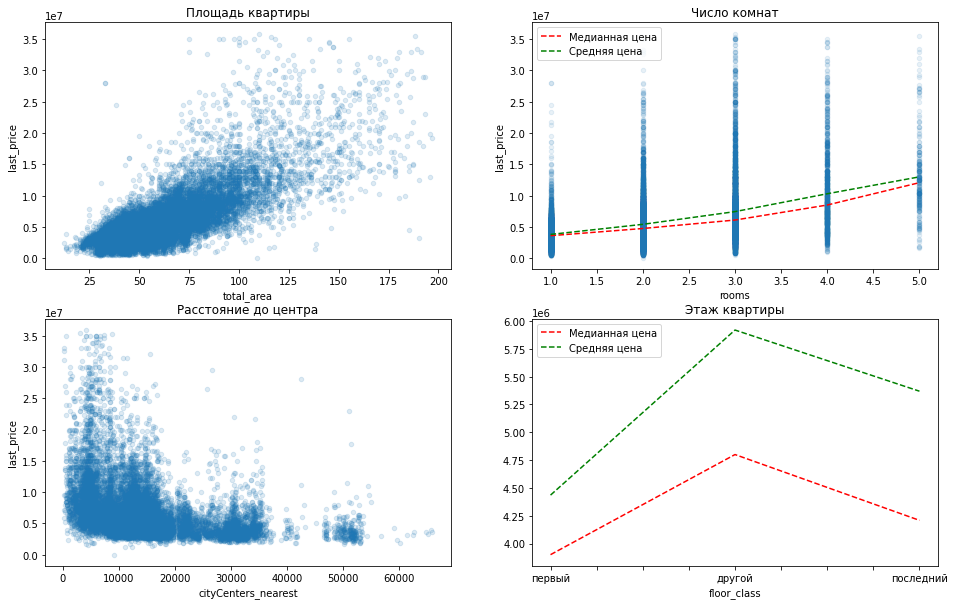

In [53]:
fix, axes = plt.subplots(2, 2, figsize=(16,10))

data.plot(x='total_area', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[0,0])
axes[0,0].set_title('Площадь квартиры')

data.plot(x='rooms', y = 'last_price', kind='scatter', alpha=0.1,  ax=axes[0,1])
data.pivot_table(index='rooms',
                 values='last_price',
                 aggfunc='median').plot(color='red', linestyle='dashed', ax=axes[0,1])
data.pivot_table(index='rooms',
                 values='last_price',
                 aggfunc='mean').plot(color='green', linestyle='dashed', ax=axes[0,1])
axes[0,1].legend(['Медианная цена', 'Средняя цена'])
axes[0,1].set_title('Число комнат')

data.plot(x='cityCenters_nearest', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[1,0])
axes[1,0].set_title('Расстояние до центра')

#data.plot(x='floor_class', y = 'last_price', kind='scatter', alpha=0.1, ax=axes[1,1])
data.groupby('floor_class')['last_price'].median().plot(color='red', linestyle='dashed', ax=axes[1,1])
data.groupby('floor_class')['last_price'].mean().plot(color='green', linestyle='dashed', ax=axes[1,1])
axes[1,1].legend(['Медианная цена', 'Средняя цена'])
axes[1,1].set_title('Этаж квартиры')

Графики хорошо согласуются с расчитанными коэффициентами корреляции. Дополнительно можно отметить следующие особенности:
- Увеличение площади практически линейно увеличивает стоимость квартиры. Разброс цен также увеличивается с ростом площади, при этом цена самых дешевых и самых дорогих квартир мало зависит от площади;
- Число комнат практически линейно влияет на среднюю стоимость квартиры, при этом разброс цен довольно высок и растет с ростом числа комнат. Некоторое снижение разброса для квартир с более чем 3 комнатами вероятно объясняется тем, что при подготовке данных были исключены квартиры дороже 36 млн.
- Увеличение расстояния от центра в общем случае снижает стоимость квартиры, при наблюдаюестся несколько областей (около 5 км, до 10 км, до 20 км, 30 км, около 50 км) с разным разбросом цен и разной скоростью убывания цены с удалением от центра. Вероятно это связано с географическими особенностями Санкт-Петербурга и Ленинградской области (исторический центр города, город в пределах КАД и т.д.).
- Как и следовало ожидать минимальную стоимость с минимальным разбросом имеют квартиры на первом этаже. Квартиры на последнем этаже также в среднем дешевле прочих квартир, но дороже квартир на первом этаже. Разброс стоимости квартир на последнем этаже и на прочих практически не отличается.

Рассмотрим влияние даты размещения на стоимость квартиры:

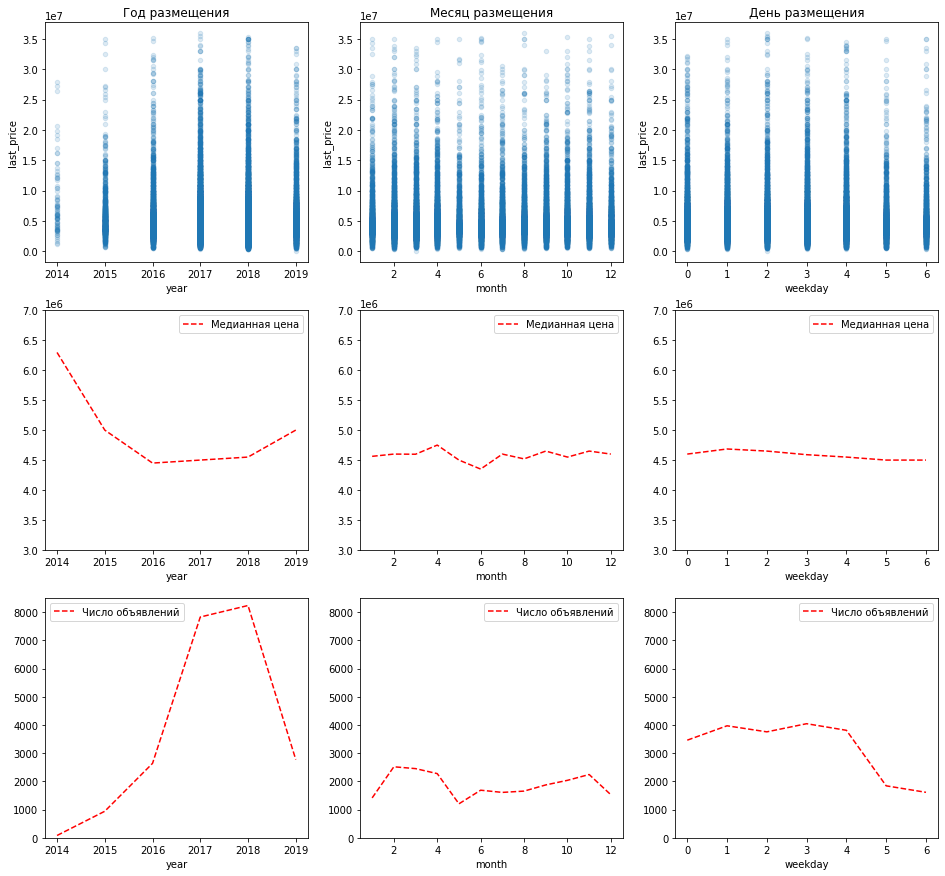

In [54]:
#Создание подграфиков:
fix, axes = plt.subplots(3, 3, figsize=(16, 15))

#Построение подграфиков:
data.plot(x='year', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[0,0])
data.pivot_table(index='year',
                 values='last_price',
                 aggfunc='median').plot(color='red', linestyle='dashed', ax=axes[1,0])
axes[1, 0].legend(['Медианная цена'])
axes[0, 0].set_title('Год размещения')

data.pivot_table(index='year',
                 values='last_price',
                 aggfunc='count').plot(color='red', linestyle='dashed', ax=axes[2, 0])
axes[2, 0].legend(['Число объявлений'])


data.plot(x='month', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[0, 1])
data.pivot_table(index='month',
                 values='last_price',
                 aggfunc='median').plot(color='red', linestyle='dashed', ax=axes[1, 1])
axes[1, 1].legend(['Медианная цена'])
axes[0, 1].set_title('Месяц размещения')

data.pivot_table(index='month',
                 values='last_price',
                 aggfunc='count').plot(color='red', linestyle='dashed', ax=axes[2, 1])
axes[2, 1].legend(['Число объявлений'])

data.plot(x='weekday', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[0, 2])
data.pivot_table(index='weekday',
                 values='last_price',
                 aggfunc='median').plot(color='red', linestyle='dashed', ax=axes[1, 2])
axes[1, 2].legend(['Медианная цена'])
axes[0, 2].set_title('День размещения')

data.pivot_table(index='weekday',
                 values='last_price',
                 aggfunc='count').plot(color='red', linestyle='dashed', ax=axes[2, 2])
axes[2, 2].legend(['Число объявлений'])

#Зададим одинаковый масштаб по цене:
for i in range(3):
    axes[1, i].set_ylim([3e6, 7e6])
    
    
#Зададим одинаковый масштаб по цене:
for i in range(3):
    axes[2, i].set_ylim([0, 8.5e3])

Дата размещения практически не влияет на стоимость квартиры.  
Можно отметить небольшое снижение медианной стоимости квартиры в период с 2014 по 2016 год, связанное вероятно развитием сервиса и ростом числа объявлений, а также внешними факторами (экономический кризис).  
В конце весны - начале лета наблюдается небольшое снижение стоимости квартир, сопровождающее также снижением числа объявлений. Вероятно это можно объяснить сезоном отпусков и связанным с этим снижением количества крупных покупок.  
В выходные дни снижается число размещаемых объявлений, однако это не оказывает влияния на стоимость квартир.

#### Вывод

Наибольшее влияние на стоимость квартиры оказывают параметры связанные с её размерами:
- общая площадь;
- жилая площадь и площадь кухни;
- высота потолков;
- число комнат.
Также стоимость квартир возрастает при увеличении числа парков и прудов в окрестности.  
Количество балконов оказывает сильное влияние при переходе к нестандартному - более 3.

К снижению стоимости квартиры приводит главным образом удаление от населенного пункта.  

Дата размещения практически не влияет на стоимость квартиры. Небольшое влияние оказывает год размещения - в период с 2014 по 2016 происходило падение стоимости.

### Наиболее популярные населенные пункты

Рассчитаем наиболее популярные по числу объявлений населенные пункты и среднюю цену квадратного метра жилья в них:

In [55]:
data_by_locality = data.pivot_table(index='locality_name', 
                                    values='price_per_square', 
                                    aggfunc=['count', 'mean'])

data_by_locality.columns = ['Число объявлений', 'Средняя цена кв. м']

top10_locality = data_by_locality.sort_values(by='Число объявлений', ascending=False).head(10)

top10_locality.sort_values(by='Средняя цена кв. м', ascending=False)

,Число объявлений,Средняя цена кв. м
locality_name,,
Санкт-Петербург,14808,110738.886843
Пушкин,352,102528.131581
Кудрово,446,95072.601015
Парголово,320,90406.049365
Мурино,557,85548.657143
Шушары,434,78254.497583
Колпино,333,75336.093700
Гатчина,305,68811.372828
Всеволожск,385,68582.742200


Большая часть объявлений приходится на г. Санкт-Петербург и его агломерацию (Мурино, Шушары, Пушкин и т.д.), также в топ 10 по числу объявлений входят относительно крупные города Ленинградской области - Гатчина и Выборг. Набольшая средняя стоимость квадратного метра среди наиболее популярных населенных пунктов характерна для самого г. Санкт-Петербурга - 109 тыс., а наименьшая для г. Выборга - 57 тыс.

### Влияние параметров, на примере Санкт-Петербурга

Выделим квартиры, расположенные в г. Санкт-Перербург:

In [56]:
spb_data = data[data['locality_name'] == 'Санкт-Петербург'].copy()

#### Выделение сегмента "квартир в центре"

Округлим расстояние до центра с точностью до километров:

In [57]:
spb_data['to_center_km'] = spb_data['cityCenters_nearest']/1000
spb_data['to_center_km'] = spb_data['to_center_km'].round()

Распределение объявлений по расстоянию от центра:

<AxesSubplot:>

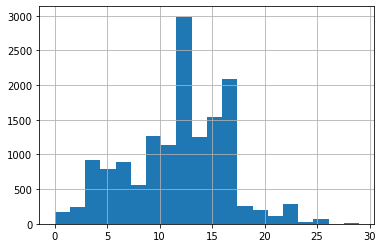

In [58]:
spb_data['to_center_km'].hist(bins=20)

Зависимость средней стоимости квартир от растояния от центра:

<AxesSubplot:xlabel='to_center_km'>

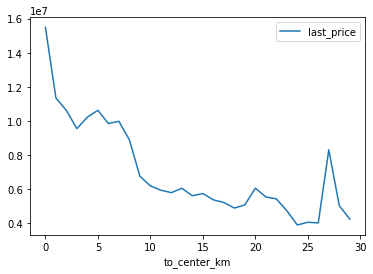

In [59]:
spb_data.pivot_table(index='to_center_km', values='last_price', aggfunc='mean').plot()

В качестве граница центра г. Санкт-Петербурга можно взять расстояние приблизительно в 9 км от центра, поскольку после этого расстояния стоимость квартир резко снижается.
Выделим квартиры в центре в отдельный датафрейм:

In [60]:
spb_center = spb_data[spb_data['to_center_km']<9]

#### Влияние параметров квартиры на стоимость

**Распределение квартир по площади:**

<AxesSubplot:>

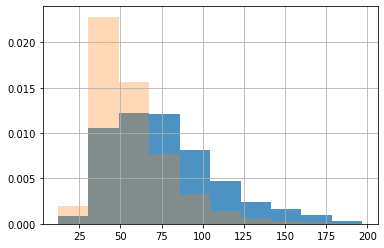

In [61]:
spb_center['total_area'].hist(density=True, alpha=0.8)
data['total_area'].hist(density=True, alpha=0.3)

В центре Санкт-Петербурга больше квартир большой площади, и квартиры в целом более разнообразны (менее выражен максимум около 50 кв. м).

**Распределение квартир по стоимости:**

<AxesSubplot:>

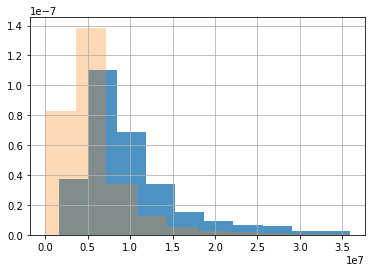

In [62]:
spb_center['last_price'].hist(density=True, alpha=0.8)
data['last_price'].hist(density=True, alpha=0.3)

Максимум распределения совпадает, однако в центре Санкт-Петербурга дешевые квартиры встречаются существенно реже, при этом чаще встречаются более дорогие квартиры.

**Распределение квартир по числу комнат:**

<AxesSubplot:>

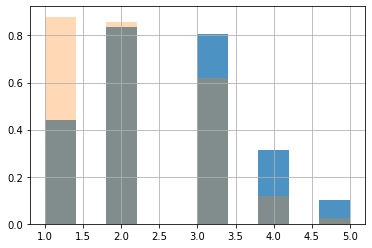

In [63]:
spb_center['rooms'].hist(density=True, alpha=0.8)
data['rooms'].hist(density=True, alpha=0.3)

Приблизительно с одинаковой вероятностью встречаются двухкомнатные квартиры.  
Однокомнатных квартир в центре Петербурга меньше, но заметно больше квартир повышенной комнатности.

**Гистограмма распределения квартир по высоте потолков:**

<AxesSubplot:>

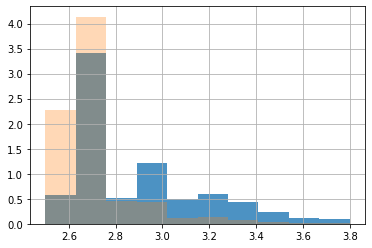

In [64]:
spb_center['ceiling_height'].hist(density=True, alpha=0.8)
data['ceiling_height'].hist(density=True, alpha=0.3)

Как и в случае остальных зависимостей наиболее рааспространенная высота потолка в центре совпадает с высотой в общем случае, при этом в центре Санкт-Петербурга более распространены квартиры с более высокими потолками. А квартиры с меньшей высотой потолков (2,5 м) наоборот относительно менее распространены.

In [65]:
price_corr_spb = spb_center.corr()['last_price'].sort_values(ascending=False)

pd.DataFrame({'spb':price_corr_spb, 'all':price_correlation}).sort_values(by='all')

,spb,all
cityCenters_nearest,-0.084046,-0.340200
parks_nearest,-0.080363,-0.161133
ponds_nearest,-0.052254,-0.133886
kitchen_area_ratio,-0.072227,-0.097748
airports_nearest,0.089099,-0.032878
weekday,-0.010768,-0.016343
studio,-0.015877,-0.015975
year,0.002944,-0.007373
open_plan,-0.005284,-0.000900
month,-0.030568,-0.000532


Стоимость квартир в центре Петербурга определяют в основном те же факторы что и квартир в остальных населенных пунктах. Большинство параметров влияет меньше чем в общем случае, наиболее сильное снижение влияния наблюдается для следующих параметров:  
- высота потолков;
- расстояние до центра;
- число парков и прудов.

При этом количество балконов и этаж квартиры в центре Петербурга влияют сильнее, чем в общем по всем населенным пунктам.  
С основными параметрами ознакомися более подробно:

Text(0.5, 1.0, 'Этаж квартиры, приведенная медианная цена')

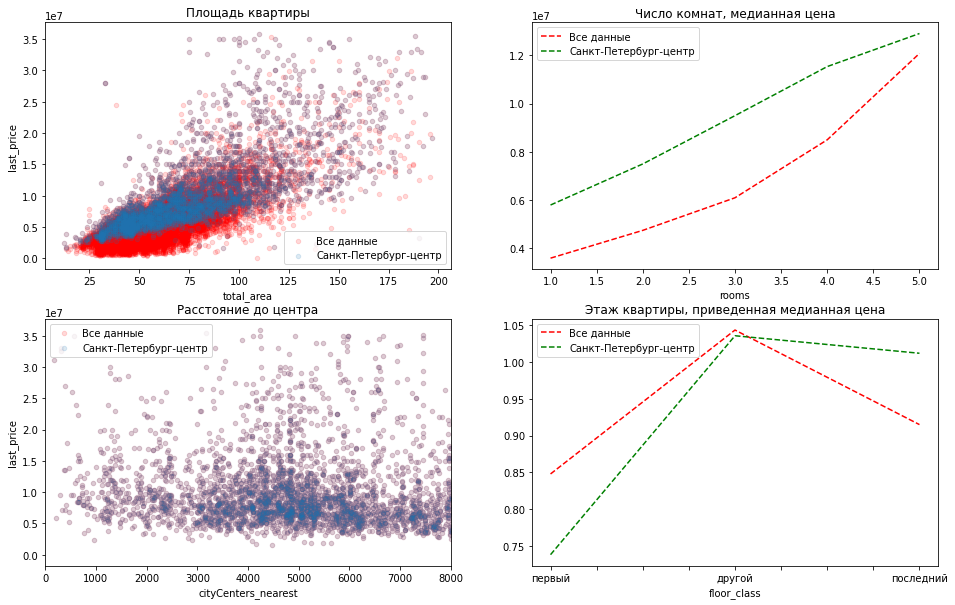

In [66]:
fix, axes = plt.subplots(2, 2, figsize=(16,10))

data.plot(x='total_area', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[0,0], color='red')
spb_center.plot(x='total_area', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[0,0])
axes[0,0].legend(['Все данные', 'Санкт-Петербург-центр'])
axes[0,0].set_title('Площадь квартиры')


data.pivot_table(index='rooms',
                 values='last_price',
                 aggfunc='median').plot(color='red', linestyle='dashed', ax=axes[0,1])
spb_center.pivot_table(index='rooms',
                 values='last_price',
                 aggfunc='median').plot(color='green', linestyle='dashed', ax=axes[0,1])
axes[0,1].legend(['Все данные', 'Санкт-Петербург-центр'])
axes[0,1].set_title('Число комнат, медианная цена')

data.plot(x='cityCenters_nearest', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[1,0], color='red')
spb_center.plot(x='cityCenters_nearest', y = 'last_price', kind='scatter', alpha=0.15, ax=axes[1,0])
axes[1,0].set_xlim(0, 8000)
axes[1,0].legend(['Все данные', 'Санкт-Петербург-центр'])
axes[1,0].set_title('Расстояние до центра')

#Квартиры в центре Санкт-Петербурга дороже остальных, для проверки зависимости разделим медианы по группам, на общую медиану:
(data.groupby('floor_class')['last_price'].median() /
 data['last_price'].median()).plot(color='red', linestyle='dashed', ax=axes[1,1])
(spb_center.groupby('floor_class')['last_price'].median() / 
 spb_center['last_price'].median()).plot(color='green', linestyle='dashed', ax=axes[1,1])
axes[1,1].legend(['Все данные', 'Санкт-Петербург-центр'])
axes[1,1].set_title('Этаж квартиры, приведенная медианная цена')

Графики подтверждают вывод о об аналогичном влияниянии параметров. Можно дополнительно отметить следующее:
- в центре Санкт-Петербурга меньше разброс стоимости квартир в зависимости от полощади. Преимущественно разброс уменьшен за счет отсутствия слишком дешевых квартир.
- стоимость квартир практически одинаково растет с увеличением числа комнат, отличие заключается в минимальной стоимости квартир в центре Санкт-Петербурга.
- расстояние до центра практически не влияет на стоимость квартир, при этом распределение объявлений в центре Санкт-Петербурга практически идентично распределению среди всех объявлений.
- в центре Санкт-Петербурга наблюдает большее (относительное) снижение цены квартир на первых этажах и меньшее снижение цены квартир на последних этажах, в отличии от всех данных.

### Выводы

Большинство параметров квартир в объявлениях имеет распределение близкое к распределению Пуассона. Это говорит о правдоподобности большинства параметров в объявлениях (за исключением некоторых явных ошибок). Поскольку распределение Пуассона слабо падает справа, редкие большие значения параметров могут вносить искажения в наблюдаемые зависимости. Для предотвращения этого, редкие и выбивающиеся значения были исключены.  

Наибольшее влияние на стоимость квартиры оказывают параметры связанные с её размерами:
- общая площадь;
- жилая площадь и площадь кухни;
- высота потолков;
- число комнат.
Также стоимость квартир возрастает при увеличении числа парков и прудов в окрестности.  
Количество балконов оказывает наиболее сильное влияние при переходе к нестандартному - более 3.

К снижению стоимости квартиры приводит главным образом удаление от населенного пункта. Также ниже оказывается стоимость квартир на первых (наиболее сильное снижение) и последних (менее сильное снижение) этажах.  

Дата размещения практически не влияет на стоимость квартиры. Небольшое влияние оказывает год размещения - в период с 2014 по 2016 происходило падение стоимости, а в период с 2016 по 2019 - небольшой рост.  

Наибольшее число объявлений в базе приходится на Санкт-Петербург и его агломерацию. Также в топ-10 по числу объявлений вошли относительно крупные города Ленинградской области - Гатчина и Выборг. Наибольшая стоимость квадратного метра характерная для самого Санкт-Петербурга.

В случае Санкт-Петербурга к "центру" относятся квартиры, расположенные не дальше 9 км от географического центра.  
Для квартир в этой области наблюдается меньший разброс цены, зависимости аналогичны общим зависимостям. Преимущественно зависимости в центре Санкт-Петербурга выражены менее сильно (наибольшее снижение наблюдается для "расстояния от центра" - поскольку квартиры уже расположены в центре). Для некоторых параметров (число балконов, этаж) для центра Санкт-Петербурга вляние наоборот более выражено, так, например, в центре Санкт-Петербурга наблюдает большее (относительное) снижение цены квартир на первых этажах и меньшее снижение цены квартир на последних этажах, в отличии от всех данных.

## Общий вывод

Проанализирована база данных объявлений о продаже квартир. Представленные в базе данные выглядят преимущественно правдоподобно.  
Данные предобработаны: 
- исключены практически константные показатели (`is_apartment`);
- проанализированы и заполнены пропуски в столбцах;
- изменены типы данных для ряда столбцов.

В ходе предобработки обнаружена часть записей без указания географических параметров (около 23% от общего числа) с существенно меньшей ценой продажи. Такие потенциально являются мошенническими и должны рассматриваться более тщательно.


In [67]:
(data
     .pivot_table(
         index='position_given',
         values='last_price',
         aggfunc=['median', 'count'])
     .rename({'median':'Медиана',
              'count':'Всего'}, axis=1)
)

,Медиана,Всего
,last_price,last_price
position_given,,
False,2800000.0,5325
True,5200000.0,17168


Были рассчитаны и добавлены следующие данные:
- стоимость квадртаного метра;
- день, месяц и год публикации объявления;
- тип этажа (первый/последний/другой);
- доли жилой и кухонной площади.

Также были исключения дублирования названий населенных пунктов из них был исключен тип (город, п.г.т., поселок и т.д.).  

Проанализировано распределение параметров квартир в объвлениях. 
Установлено, что в большинстве случаев параметры имеют распределение Пуассона, что подтверждает их правдоподобие.  
Были исключены редкие (преимущественно большие) или явно-ошибочные значения.

Наибольшее влияние на стоимость квартиры оказывают параметры связанные с её размерами:
- общая площадь;
- жилая площадь и площадь кухни;
- высота потолков;
- число комнат.
Также стоимость квартир возрастает при увеличении числа парков и прудов в окрестности.  
Количество балконов оказывает наиболее сильное влияние при переходе к нестандартному - более 3.  

Сильная корреляция, наблюдаемая между стоимостью квартиры и ценой квадратного метра, должна рассматриваться с большой осторожностью, поскольку цена квадратного метра была рассчитана из стоимости квартиры и уже содержит информацию о ней.

К снижению стоимости квартиры приводит главным образом удаление от населенного пункта. Также ниже оказывается стоимость квартир на первых (наиболее сильное снижение) и последних (менее сильное снижение) этажах.  

Дата размещения практически не влияет на стоимость квартиры. Небольшое влияние оказывает год размещения - в период с 2014 по 2016 происходило падение стоимости, а в период с 2016 по 2019 - небольшой рост.  

Наибольшее число объявлений в базе приходится на Санкт-Петербург и его агломерацию. Также в топ-10 по числу объявлений вошли относительно крупные города Ленинградской области - Гатчина и Выборг. Наибольшая стоимость квадратного метра характерная для самого Санкт-Петербурга.

В случае Санкт-Петербурга к "центру" относятся квартиры, расположенные не дальше 9 км от географического центра.  
Для квартир в этой области наблюдается меньший разброс цены, зависимости аналогичны общим зависимостям. Преимущественно зависимости в центре Санкт-Петербурга выражены менее сильно (наибольшее снижение наблюдается для "расстояния от центра" - поскольку квартиры уже расположены в центре). Для некоторых параметров (число балконов, этаж) для центра Санкт-Петербурга вляние наоборот более выражено, так, например, в центре Санкт-Петербурга наблюдает большее (относительное) снижение цены квартир на первых этажах и меньшее снижение цены квартир на последних этажах, в отличии от всех данных.